In [337]:
import numpy as np
from scipy.stats import binom
from scipy.stats import truncnorm
from scipy.stats import gamma
from scipy.special import factorial

In [338]:
# Parameters 

h = 1/7
pho = 2/3
g = 2/3
R = 19
T = 7*R

In [339]:
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [340]:
def K(k, betas):
    K = np.zeros((4,4))
    K[0, 0], K[0, 1], K[1, 1], K[1, 2], K[2, 2], K[2, 3], K[3, 3] = np.exp(-betas[k]*h), 1-np.exp(-betas[k]*h), np.exp(-h*pho), 1-np.exp(-h*pho), np.exp(-h*g), 1-np.exp(-h*g), 1
    return(K)

In [341]:
def calcul(Y, G, P, Q):
    Q_new = Q
    for s in np.argwhere(Q == 0):
        if Y[s[0]][s[1]]==0 or G[s[0]][s[1]]==0 or P[s[0]][s[1]]==0:
             Q_new[s[0]][s[1]] = 1
    M = np.multiply(Y, np.multiply(G, np.divide(P, Q)))
    for s in np.argwhere(Q == 0):
        M[s[0]][s[1]] = 0
    return M

In [376]:
def multiply_log(Y, M):
    M_new = M
    for s in np.argwhere(M == 0):
        if Y[s[0]][s[1]]==0:
            M_new[s[0]][s[1]]=1
    return np.multiply(Y, np.log(M_new))

In [377]:
def log_factorial(Y):
    M = np.zeros((4,4))
    M[1][2] = np.sum(np.log(np.arange(1, Y[1][2])))
    return M

In [396]:
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def PAL(y, theta, R=19):
    
    X = np.array([X1, X2, X3, X4]) 
    B = theta[:16].reshape(4,4)
    L = np.zeros((R, 4))

    for r in range(R):
        G = np.zeros((7, 4, 4, 4))
        
        for i in range(6):
            I =  X[:, 2]   
            betas = np.matmul(B, I)/8000

            for k in range(4):
                #print(k, K(k, betas))
                G[i, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))
                #print(np.outer(np.ones(4), Lambda[k]), K(k, betas), G[i, k])
                X[k] = (np.matmul(np.ones(4).T, G[i, k])).T
                #print(X[k])
        #print(X)        
        I =  X[:, 2]   
        betas = np.matmul(B, I)/8000
        
        for k in range(4):
            G[6, k] = np.multiply(np.outer(X[k], np.ones(4)), K(k, betas))
            M = np.zeros((4,4))
            Q = np.zeros((4,4))
            Q[1, 2] = theta[k+16]
            
            for i in range(7):
                M = M + np.multiply(G[i, k], Q)
                
            Y_bar = np.zeros((4,4))
            Y_bar[1, 2] = y[r, k]
            G_bar = np.multiply(np.outer(np.ones(4), np.ones(4))-Q, G[i, k]) + calcul(Y_bar, G[6, k], Q, M)
            X[k] = np.transpose(np.dot(np.transpose(np.ones(4)), G_bar))
            L[r, k] = -np.dot(np.transpose(np.ones(4)), np.dot(M, np.ones(4))) + np.dot(np.transpose(np.ones(4)), np.dot(multiply_log(Y_bar, M), np.ones(4))) - np.dot(np.transpose(np.ones(4)), np.dot(log_factorial(Y_bar), np.ones(4)))
        #print(X)
    return L

In [397]:
theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
PAL(Y, theta, R=19)

array([[ -16.        ,  -16.        ,  -17.70787505,  -16.        ],
       [ -16.        ,  -16.        ,  -20.78749174,  -16.        ],
       [ -16.        ,  -16.        ,  -17.79175947,  -16.        ],
       [ -64.47118135, -254.97838956, -212.86618167,  -31.10441257],
       [-212.86618167, -916.45849071, -732.86222028, -126.32063971],
       [-254.97838956, -911.12577192, -722.57306225,  -77.26170176],
       [-225.34258675, -616.00947056, -581.12488109,  -22.57925121],
       [ -74.00360522, -122.63176026, -316.22094865,  -83.88974314],
       [ -46.67186011,  -49.50507345,  -97.55795946,  -33.50230785],
       [ -16.69314718,  -17.79175947,  -35.9872145 ,  -20.78749174],
       [ -16.        ,  -20.78749174,  -43.89927138,  -19.17805383],
       [ -16.        ,  -20.78749174,  -31.10441257,  -16.69314718],
       [ -16.        ,  -16.        ,  -20.78749174,  -19.17805383],
       [ -16.        ,  -16.        ,  -16.        ,  -16.        ],
       [ -16.        ,  -16.      

In [398]:
def log_PAL(y, theta, R=19):
    L = PAL(y, theta, R=19)
    for r in range(1, R):
        L[r] = np.sum(L[:r, :], axis=0)
    return L

In [399]:
theta = np.concatenate((np.random.gamma(5, 1, 16), truncnorm.rvs(a=0, b=1, loc=0.5, scale=0.5, size=4)), axis=None)
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
log_PAL(Y, theta, R=19)

array([[-1.60000000e+01, -1.60000000e+01, -1.75837744e+01,
        -1.60000000e+01],
       [-1.60000000e+01, -1.60000000e+01, -1.75837744e+01,
        -1.60000000e+01],
       [-3.20000000e+01, -3.20000000e+01, -3.51675487e+01,
        -3.20000000e+01],
       [-6.40000000e+01, -6.40000000e+01, -7.03350974e+01,
        -6.40000000e+01],
       [-1.28000000e+02, -1.28000000e+02, -1.40670195e+02,
        -1.28000000e+02],
       [-2.56000000e+02, -2.56000000e+02, -2.81340390e+02,
        -2.56000000e+02],
       [-5.12000000e+02, -5.12000000e+02, -5.62680779e+02,
        -5.12000000e+02],
       [-1.02400000e+03, -1.02400000e+03, -1.12536156e+03,
        -1.02400000e+03],
       [-2.04800000e+03, -2.04800000e+03, -2.25072312e+03,
        -2.04800000e+03],
       [-4.09600000e+03, -4.09600000e+03, -4.50144623e+03,
        -4.09600000e+03],
       [-8.19200000e+03, -8.19200000e+03, -9.00289247e+03,
        -8.19200000e+03],
       [-1.63840000e+04, -1.63840000e+04, -1.80057849e+04,
      

In [400]:
def log_prior(theta):
    log_prior = 0
    for i in range(16):
        if gamma.pdf(theta[i], a=5, loc=0, scale=1)==0:
            return -100000
        else:
            log_prior = log_prior + np.log(gamma.pdf(theta[i], a=5, loc=0, scale=1))
    for i in range(4):
        if truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)==0:
            return -10000
        else:
            log_prior = log_prior + np.log(truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5))
    return log_prior

In [401]:
def logL(y, theta, R=19):
    L = np.zeros(4)
    for k in range(4):
        L[k] = np.sum(log_PAL(y, theta, R=19)[:, k], axis=0)
    return L+log_prior(theta)

In [402]:
def MCMC(y, N, R=19):                      # Metropolis-Hastings
    
    theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)    
    thetas = np.array([theta for i in range(N)])
    L = logL(y, theta, R=19)
    #n_params = 20
    #cov_matrix = np.eye(n_params) * initial_cov
    #mean_theta = theta.copy()
    
    for n in range(1, N):
        theta_new = np.concatenate((get_truncated_normal(mean=theta[:16], sd=0.15, low=0, upp=np.inf).rvs(), get_truncated_normal(mean=theta[16:], sd=0.15, low=0, upp=1).rvs()), axis=None)
        
        #while log_prior(theta_new)==-100000:
            #theta_new =  np.concatenate((get_truncated_normal(mean=theta[:16], sd=0.15, low=0, upp=np.inf).rvs(), get_truncated_normal(mean=theta[16:], sd=0.15, low=0, upp=1).rvs()), axis=None)

        L_new = logL(y, theta_new, R=19) 
        v = L_new - L
        #print(L_new)
        
        for k in range(4):      
            u = np.random.uniform()
            
            if np.log(u)<v[k]:
                L[k] = L_new[k]
                thetas[n, 4*k:4*k+4] = theta_new[4*k:4*k+4]
                thetas[n, 16+k] = theta_new[16+k]
                theta[4*k:4*k+4] = theta_new[4*k:4*k+4]
                theta[16+k] = theta_new[16+k]
                
            else:
                thetas[n, 4*k:4*k+4] = theta[4*k:4*k+4]
                thetas[n, 16+k] = theta[16+k]  

            #if n % adapt_interval == 0:
               # mean_theta = np.mean(thetas, axis=0)
               # cov_matrix = np.cov(thetas.T) + np.eye(n_params) * 1e-6 
                
        #print(theta)
    return thetas

In [ ]:
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
thetas = MCMC(Y, 10000, R=19)

In [204]:
thetas[5000:, 5]

array([], dtype=float64)

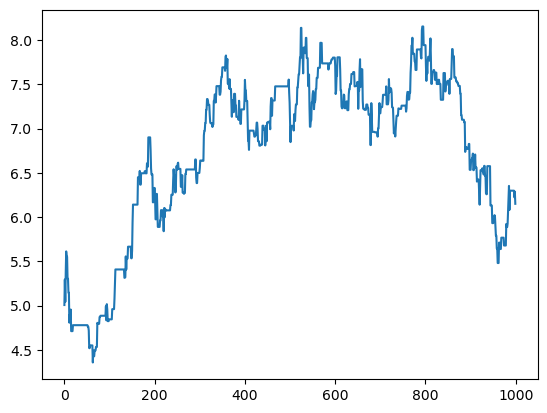

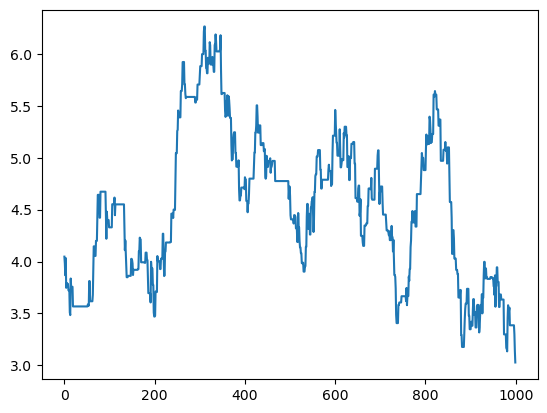

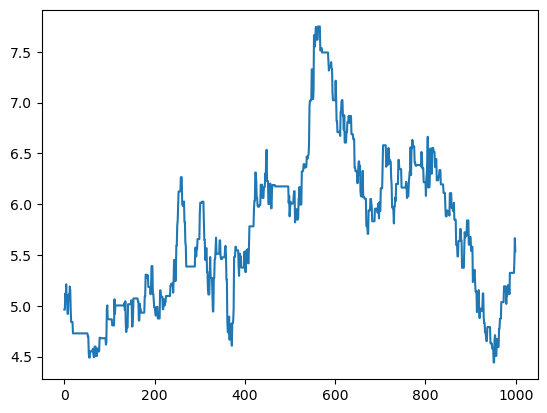

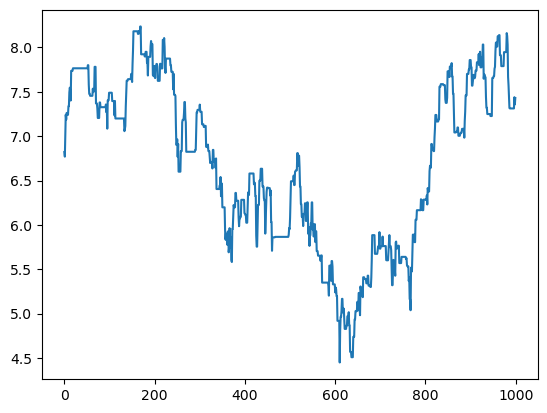

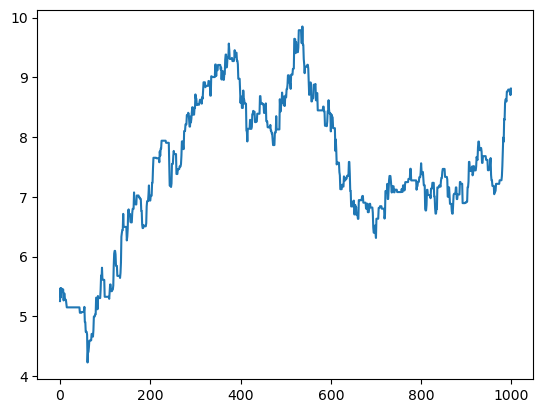

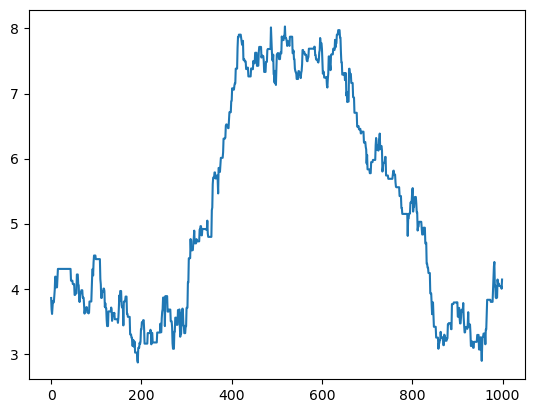

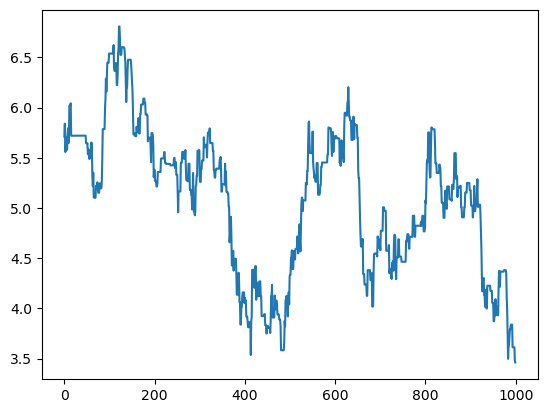

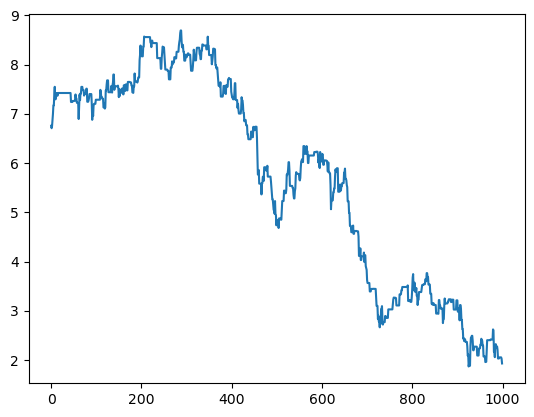

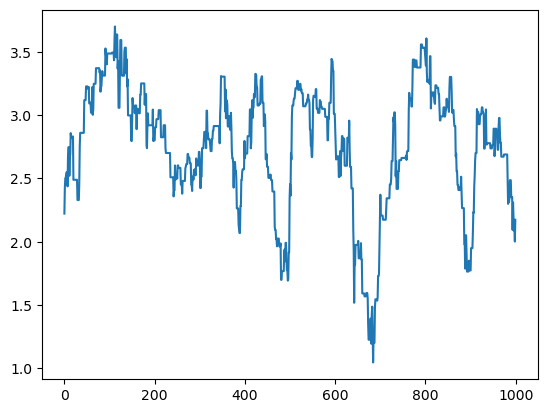

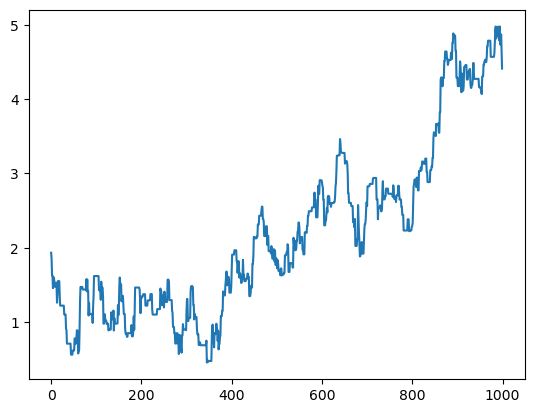

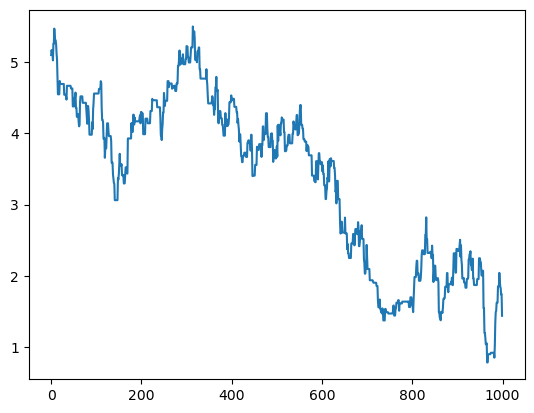

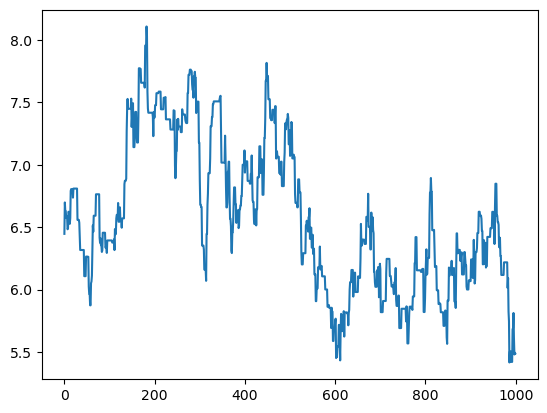

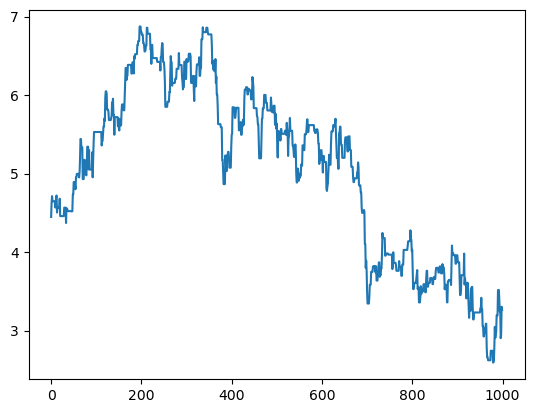

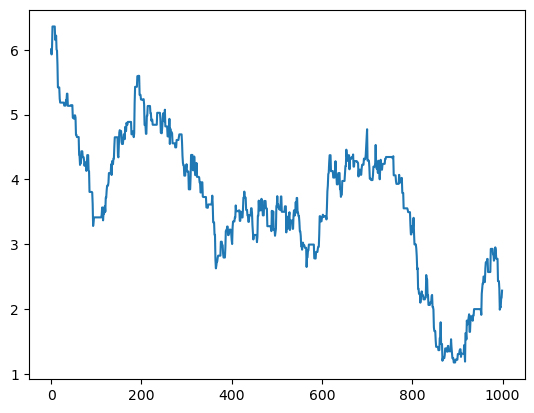

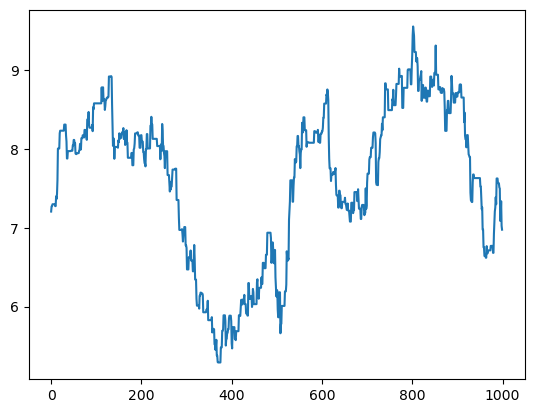

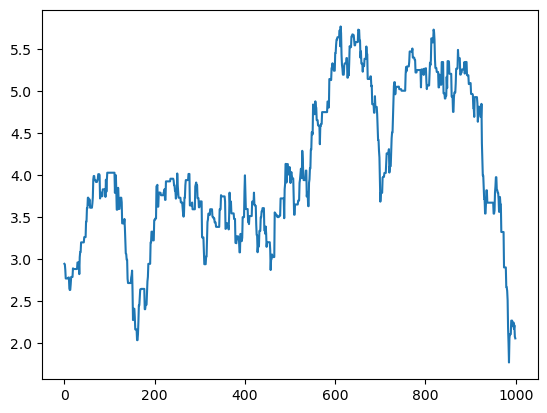

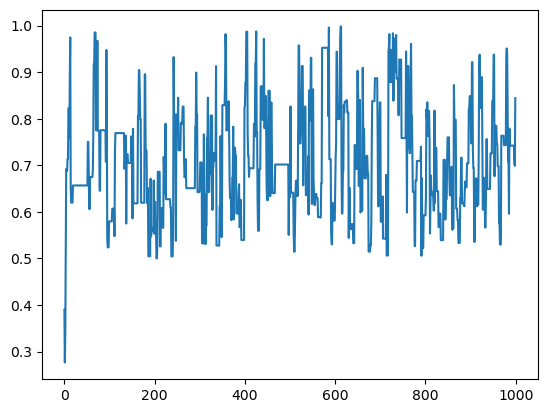

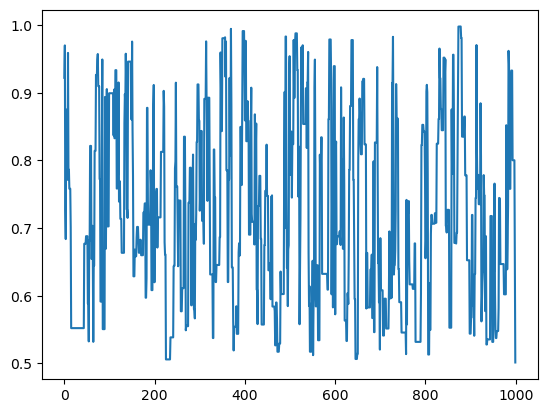

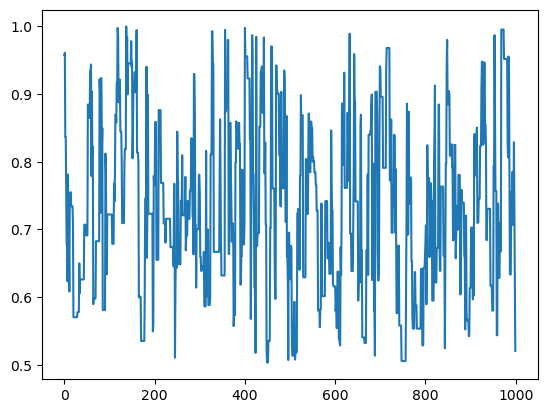

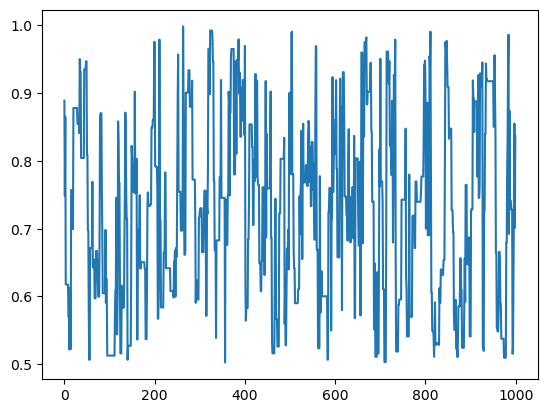

In [404]:
import matplotlib.pyplot as plt

for k in range(20):
    plt.plot(thetas[:, k])
    plt.show()

In [ ]:
theta_mean = np.sum(thetas[5000:])/5000

In [ ]:
n = np.array(949, 1700, 3467, 1985])
NGM = np.zeros((4,4))  #Next Generation Matrix
betas = theta_mean[:16].resahpe(4,4)
for i in in range(4):
    for j in range(4):
        NGM[i, j] = n[i]*betas[i,j]/8000*g
print(np.abs(np.linealg.eig(NGM)))